In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [40]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

C:\Users\dany\AppData\Local\Temp\ipykernel_26936\3125191635.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = positive.append(negative)


In [41]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [42]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [5]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [20]:
from nltk import ngrams

In [9]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [10]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [11]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [12]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [13]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [15]:
list(vec.vocabulary_.items())[:5]

[('kilz0x33d', 46422),
 ('затишье', 136743),
 ('перед', 180200),
 ('буряй', 108901),
 ('нам', 163272)]

In [23]:
y_train.shape

(170125,)

In [24]:
clf = LogisticRegression(random_state=42, max_iter=170126 )
clf.fit(bow, y_train)

LogisticRegression(max_iter=170126, random_state=42)

In [25]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.77      0.76      0.77     28463
    positive       0.76      0.78      0.77     28246

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



Попробуем сделать то же самое для триграмм:

In [26]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\dany\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.85      0.57      0.68     41451
    positive       0.39      0.73      0.50     15258

    accuracy                           0.61     56709
   macro avg       0.62      0.65      0.59     56709
weighted avg       0.73      0.61      0.64     56709



In [27]:
bow.shape

(170125, 1326842)

(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

In [30]:
# потому что фичей во втором случае получается больше 1 миллиона, соответсвенно матрица более разряженная
# и модель переобучается

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом 
количестве документов, у него высокий TF-IDF.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.74      0.77      0.75     26898
    positive       0.78      0.76      0.77     29811

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## PMI

Можно оценить взаимосвязь слов в корпусе и понять, какие биграммы наиболее часто встречаются в тексте. Для этого можно использовать метрику PMI (Pointwise Mutual Information) - поточечная взаимная информация. Метрика PMI для двух слов вычисляется по формуле:

$$pmi(x; y) = log \frac{p(x,y)}{p(x)p(y)} $$

Здесь p(y|x) - вероятность встретить слово $y$ после $x$, $p(y)$ - вероятность встретить слово $y$.

Оценим важность биграмм в нашем обучающем корпусе.

In [42]:
from nltk import collocations 
nltk.download('genesis')

print(type(nltk.corpus.genesis.words('english-web.txt')))
bigram_measures = collocations.BigramAssocMeasures()
# bigram_finder.apply_freq_filter(5)
bigram_finder = collocations.BigramCollocationFinder.from_documents([nltk.word_tokenize(x) for x in x_train])
bigrams = bigram_finder.nbest(bigram_measures.pmi, 100)
print(bigrams)

[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\dany\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!


<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>
[('+375447167151', 'звоги'), ('+СОННО', '+НЕ'), ('+погода', 'крутая='), (',4', 'запирайте'), (',Дела', 'рез'), ('-10,11', 'болсо'), ('-163', '-КРАСНЫЙ'), ('-165', '-СИНИЙ'), ('-53', 'dBm'), ('-700', 'рублей.-А'), ('-800', 'нахууй'), ('-АХАХАХАХ', 'ЮБКУ'), ('-АХАХАХАХХАХАХАХАХАХХА', '-АХАХАХХАХАХАХАХАХ'), ('-Айгуль', 'Маратовна'), ('-Алина', '-Синие'), ('-Аха', 'спетросянил'), ('-ВСЕМ', 'СПОКОЙНЫХ'), ('-Вам', 'завернуть'), ('-Весело', 'кншн:3'), ('-Вообще-то', '3.Я'), ('-Восьмигрудый', 'трипи'), ('-Время', 'эмокора'), ('-Выздоравливай', 'педрилк'), ('-ГНИДОТА', '-Над'), ('-Д-Д-Д-Д-Д-Д-ДРОП', 'ЗЭ'), ('-ДЕТЕЙ', 'НАКРЫЛО'), ('-ДОВАЙТИ', 'АЛДСКУЛ'), ('-Домашка', '-кл.час'), ('-ЖАРЕНЫЙ', 'КАРТОФЕЛЬ'), ('-ЗАШЛА', 'ОДЕЛА'), ('-Защитано', '-ес'), ('-Зелено-карие', '-Киллджой'), ('-КРАСНЫЙ', '-ЧЕРНЫЕ'), ('-Керем', 'севгили'), ('-Киллджой', '-Котик'), ('-Маладец', '-Лол'), ('-НА', 'РЕАЛЬНЫХ'), ('-НАЧИНАЕТ', 'БЕСИТЬ'), ('-ОЗВУЧИВАТЕЛЬ', 'МУЛ

Можно рассмотреть другие метрики оценки важности биграмм, например, метрику правдоподобия (подробнее про вычисление метрики можно посмотреть [здесь (пункт 5.3.4)](http://www.corpus.unam.mx/cursoenah/ManningSchutze_1999_FoundationsofStatisticalNaturalLanguageProcessing.pdf):

In [43]:
bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 100)
print(bigrams)

[('(', '('), ('RT', '@'), (')', ')'), ('http', ':'), ('!', '!'), (':', 'D'), ('у', 'меня'), (':', '('), (',', 'а'), (',', 'что'), (',', 'но'), (')', 'http'), ('*', '*'), (':', ')'), ('у', 'нас'), ('(', ','), (',', '('), ('не', 'могу'), ('?', '?'), (':', '-'), (',', ')'), (')', ','), (',', ':'), (',', ','), ('@', '('), (':', ','), ('(', ':'), ('@', ')'), ('@', ','), ('&', 'lt'), ('со', 'мной'), ('@', ':'), ('(', '@'), (':', ':'), (';', ')'), ('новый', 'год'), (':', '*'), ('не', 'знаю'), (')', ':'), ('gt', ';'), (',', '@'), ('сих', 'пор'), ('а', 'я'), ('@', '@'), ('У', 'меня'), (',', 'когда'), ('lt', ';'), ('потому', 'что'), ('&', 'gt'), (';', '('), ('у', 'тебя'), ('все', 'равно'), ('с', 'тобой'), (',', 'как'), ('в', 'школу'), ('(', 'http'), ('ничего', 'не'), ('Как', 'же'), (',', 'я'), (')', '@'), ('Доброе', 'утро'), ('-', ')'), ('я', 'не'), ('--', '--'), (':', 'DD'), ('&', 'amp'), ('не', '('), ('до', 'сих'), ('самом', 'деле'), ('не', ')'), ('как', 'же'), (',', 'чтобы'), (',', '!'), ('('

Как можно заметить, немаловажную роль в текстах занимает пунктуация.

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [34]:
import nltk

In [36]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dany\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [52]:
bow.shape

(170125, 243529)

In [53]:
vec = CountVectorizer(ngram_range=(1, 1), stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, max_iter=170126)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.75      0.76     28584
    positive       0.75      0.77      0.76     28125

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [ ]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2021-09-09 13:19:45--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.243, 5.45.205.245, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cachev2-spb03.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122 [following]
--2021-09-09 13:19:46--  https://cachev2-spb03.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122
Resolving cachev2-spb03.cdn.yandex.net (cachev2-spb03.cdn.yandex.net)... 37.140.137.3, 2a02:6b8:0:2221::303
Connecting to cachev2-spb03.cdn.yandex.net (cachev2-spb03.cdn.yandex.net)|37.140.137.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.1’

mystem-3.0-linux3.1 100%[

In [ ]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [ ]:
print(mystem_analyzer.lemmatize(example))

['но', ' ', 'не', ' ', 'каждый', ' ', 'хотеть', ' ', 'что-то', ' ', 'исправлять', ':(\n']


А можно получить грамматическую информацию:

In [ ]:
mystem_analyzer.analyze(example)

[{'analysis': [{'gr': 'CONJ=', 'lex': 'но', 'wt': 0.9998906255}],
  'text': 'Но'},
 {'text': ' '},
 {'analysis': [{'gr': 'PART=', 'lex': 'не', 'wt': 1}], 'text': 'не'},
 {'text': ' '},
 {'analysis': [{'gr': 'APRO=(вин,ед,муж,неод|им,ед,муж)',
    'lex': 'каждый',
    'wt': 0.9985975623}],
  'text': 'каждый'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=непрош,ед,изъяв,3-л',
    'lex': 'хотеть',
    'wt': 1}],
  'text': 'хочет'},
 {'text': ' '},
 {'analysis': [{'gr': 'SPRO,ед,сред,неод=(вин|им)', 'lex': 'что-то', 'wt': 1}],
  'text': 'что-то'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,пе=инф,несов', 'lex': 'исправлять', 'wt': 1}],
  'text': 'исправлять'},
 {'text': ':(\n'}]

Давайте терепь используем лемматизатор майстема в качестве токенизатора.

In [ ]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [ ]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

    negative       0.77      0.74      0.76     29425
    positive       0.73      0.77      0.75     27284

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709



### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 8.2 MB 10.7 MB/s 


In [ ]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [ ]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2472, 10),))]

In [ ]:
ana[0].normal_form

'платить'

### [Natasha](https://github.com/natasha/)

В библиотеке natasha реализовано множество полезных библиотек для русского языка: разбиение на токены и предложения, русскоязычные word embeddings, морфологический, синтаксический анализ, лемматизация, извлечение именованных сущностей и т.д. Модуль библиотеки Razdel, основанный на правилах, предназначен для разбиения текста на токены и предложения.

In [ ]:
!pip install razdel

In [ ]:
from razdel import tokenize

tokens = list(tokenize('Кружка-термос на 0.5л (50/64 см³, 516;...)'))
tokens

[Substring(0, 13, 'Кружка-термос'),
 Substring(14, 16, 'на'),
 Substring(17, 20, '0.5'),
 Substring(20, 21, 'л'),
 Substring(22, 23, '('),
 Substring(23, 28, '50/64'),
 Substring(29, 32, 'см³'),
 Substring(32, 33, ','),
 Substring(34, 37, '516'),
 Substring(37, 38, ';'),
 Substring(38, 41, '...'),
 Substring(41, 42, ')')]

In [ ]:
[_.text for _ in tokens]

['Кружка-термос',
 'на',
 '0.5',
 'л',
 '(',
 '50/64',
 'см³',
 ',',
 '516',
 ';',
 '...',
 ')']

In [ ]:
!pip install natasha

     |████████████████████████████████| 34.4 MB 30 kB/s 
     |████████████████████████████████| 41 kB 102 kB/s 
     |████████████████████████████████| 49 kB 4.0 MB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=c21bb14c19f5774a60e5bb5d903ac3f80d37a2760af69683789029fcfa71fc54
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


С помощью библиотеки natasha можно также лемматизировать тексты.

In [ ]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [ ]:
text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '

natasha_lemmatize(text)

{'(': '(',
 ')': ')',
 ',': ',',
 '.': '.',
 '1': '1',
 '11': '11',
 '110-летия': '110-летие',
 '1909': '1909',
 '1909-1959': '1909-1959',
 '2010': '2010',
 '2019': '2019',
 'Twitter': 'twitter',
 '«': '«',
 '»': '»',
 'Бандера': 'бандера',
 'Бандере': 'бандера',
 'Бандеры': 'бандера',
 'В': 'в',
 'Верховной': 'верховный',
 'Виктора': 'виктор',
 'Героем': 'герой',
 'Героя': 'герой',
 'Житомирский': 'житомирский',
 'Израиля': 'израиль',
 'Йоэль': 'йоэль',
 'Лион': 'лион',
 'Львовский': 'львовский',
 'Львовской': 'львовский',
 'ОУН': 'оун',
 'Организации': 'организация',
 'Парламентарии': 'парламентарий',
 'Петру': 'петр',
 'Порошенко': 'порошенко',
 'Посол': 'посол',
 'Рады': 'рада',
 'России': 'россия',
 'Свое': 'свой',
 'Степан': 'степан',
 'Степана': 'степан',
 'Украина': 'украина',
 'Украине': 'украина',
 'Украины': 'украина',
 'Ющенко': 'ющенко',
 'Я': 'я',
 'а': 'а',
 'аналогичное': 'аналогичный',
 'антисемитизмом': 'антисемитизм',
 'антисемитских': 'антисемитский',
 'бороться': '

### mystem vs. pymorphy vs. natasha

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту, natasha тоже с этим тоже не справляется успешно:

In [ ]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'

In [ ]:
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292578, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970059, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


In [ ]:
print(natasha_lemmatize(homonym1))

{'За': 'за', 'время': 'время', 'обучения': 'обучение', 'я': 'я', 'прослушал': 'прослушать', 'больше': 'большой', 'сорока': 'сорок', 'курсов': 'курс', '.': '.'}


In [ ]:
print(natasha_lemmatize(homonym2))

{'Сорока': 'сорок', 'своровала': 'своровать', 'блестящее': 'блестящий', 'украшение': 'украшение', 'со': 'с', 'стола': 'стол', '.': '.'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [54]:
from collections import Counter

In [56]:
corpus = [token for tweet in df.text for token in nltk.word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [57]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

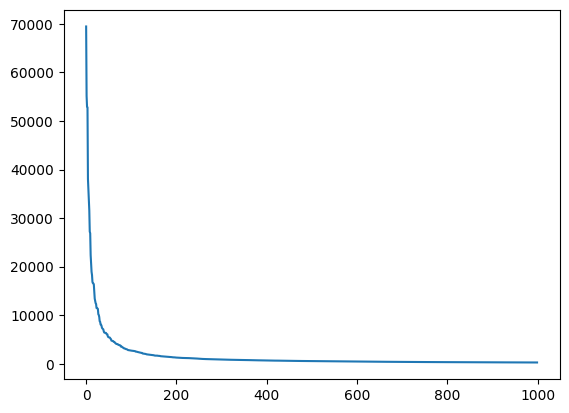

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:1000]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

1. на токенах с высокой частотой

In [68]:
freq_threshold = 10000

In [63]:
token_counts = Counter([token for tweet in df.text for token in nltk.word_tokenize(tweet) if token not in punctuation])

In [69]:
high_freq_tokens = [token for token, count in token_counts.items() if count >= freq_threshold]

In [76]:
CountVectorizer

In [86]:
vec = CountVectorizer(vocabulary=high_freq_tokens,  lowercase=False)
bow = vec.fit_transform(x_train)

In [88]:
clf = LogisticRegression()
clf.fit(bow, y_train)

LogisticRegression()

In [89]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.45      0.60      0.52     20981
    positive       0.71      0.57      0.63     35728

    accuracy                           0.58     56709
   macro avg       0.58      0.59      0.57     56709
weighted avg       0.61      0.58      0.59     56709



2. на токенах со средней частотой|

In [91]:
freq_threshold_up = 10000
freq_threshold_down = 5000

In [97]:
token_counts = Counter([token for tweet in df.text for token in nltk.word_tokenize(tweet) if token not in punctuation])

In [93]:
middle_freq_tokens = [token for token, count in token_counts.items() if count >= freq_threshold_down and count<=freq_threshold_up]

In [95]:
vec = CountVectorizer(vocabulary=middle_freq_tokens,  lowercase=False)
bow = vec.fit_transform(x_train)
clf = LogisticRegression()
clf.fit(bow, y_train)

LogisticRegression()

In [96]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.24      0.58      0.34     11714
    positive       0.83      0.53      0.65     44995

    accuracy                           0.54     56709
   macro avg       0.54      0.56      0.50     56709
weighted avg       0.71      0.54      0.59     56709



3. на токенах со средней частотой|

In [98]:
freq_threshold = 5000


In [99]:
low_freq_tokens = [token for token, count in token_counts.items() if count <= freq_threshold]

In [100]:
len(low_freq_tokens)

351045

In [102]:
vec = CountVectorizer(vocabulary=low_freq_tokens,  lowercase=False)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(max_iter=351046)
clf.fit(bow, y_train)

LogisticRegression(max_iter=351046)

In [103]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.75      0.76     28570
    positive       0.75      0.77      0.76     28139

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



был взят достаточно высокий порог для первых двух типов данных по частотности, поэтому вышло около 30 слов в первом и втором случае, что повлияло на точность модели.

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [108]:
def my_tokenizer(text):
    tokens = nltk.word_tokenize(text)
    # Apply any additional tokenization steps here
    return tokens

In [111]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=my_tokenizer)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

C:\Users\dany\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27819
    positive       1.00      1.00      1.00     28890

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [114]:
feature_names = vec.get_feature_names_out()
coef = clf.coef_[0]

In [115]:
coef_dict = dict(zip(feature_names, coef))
top_features = sorted(coef_dict.items(), key=lambda x: x[1], reverse=True)[:10]

In [116]:
for feature, coef in top_features:
    print(feature, coef)

) 58.445571349175445
d 26.92368588523117
dd 10.525564656761699
^_^ 9.377724907318662
ddd 7.8314933578964805
-d 7.592653651135805
* 7.238544049785011
: 6.186687354746176
dddd 4.7589483773119685
ddddd 3.3025870427542694


Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [117]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     32734
    positive       0.83      1.00      0.91     23975

    accuracy                           0.91     56709
   macro avg       0.92      0.93      0.91     56709
weighted avg       0.93      0.91      0.91     56709



## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [ ]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.99      1.00      1.00     27667
   positive       1.00      0.99      1.00     29042

avg / total       1.00      1.00      1.00     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

## Домашнее задание

все материалы для выполения дз в `sem2.ipynb`


### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.


### Задание 2.

найти фичи с наибольшей значимостью, и вывести их


### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

### Hashng vectorizer

In [6]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [7]:
pipeline = Pipeline([
    ('vectorizer', HashingVectorizer()),
    ('clf', LogisticRegression(max_iter=540000000))
])

In [8]:
param_grid = {
    'vectorizer__n_features': [2**16, 2**19],
    'clf__C': [1, 0.1],
}

In [9]:
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', HashingVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=540000000))]),
             param_grid={'clf__C': [1, 0.1],
                         'vectorizer__n_features': [65536, 524288]})

In [10]:
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'clf__C': 1, 'vectorizer__n_features': 524288}
Best score:  0.7455870683321087


### FCNN не смог победить ошибку

In [48]:
import tensorflow as tf
import numpy as np


tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=100, truncating="post", padding="post")
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=100, truncating="post", padding="post")


model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=100),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test))

test_loss, test_acc = model.evaluate(test_padded, y_test)
print("Test accuracy:", test_acc)

Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node 'binary_crossentropy/Cast' defined at (most recent call last):
    File "C:\Users\dany\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\dany\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\dany\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\dany\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\dany\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\dany\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\dany\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\dany\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\dany\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\dany\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\dany\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\dany\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\dany\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\dany\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\dany\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\dany\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\dany\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\dany\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\dany\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\dany\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\dany\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\dany\AppData\Local\Temp\ipykernel_26936\1443009172.py", line 24, in <module>
      model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test))
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\dany\anaconda3\lib\site-packages\keras\losses.py", line 2145, in binary_crossentropy
      y_true = tf.cast(y_true, y_pred.dtype)
Node: 'binary_crossentropy/Cast'
Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_train_function_5411]